In [1]:
import pandas as pd 
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [2]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

In [3]:
ratings = pd.read_csv("u.data", sep='\t', header=None)

In [4]:
ratings.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
ratings.columns = ['userId','itemId','rating','timestamp']

In [6]:
print(ratings['userId'].nunique())
print(ratings['itemId'].nunique())

943
1682


In [15]:
class NCF(gluon.Block):
    
    
    def __init__(self,user_vocabulary,user_emb_size,item_vocabulary,item_emb_size,hidden_units,n_outputs,**kwargs):
        
        super(NCF,self).__init__(**kwargs)
        
        with self.name_scope():
            
            self.user_emb = gluon.nn.Embedding(input_dim=user_vocabulary+1,
                                               output_dim=user_emb_size)
            self.item_emb = gluon.nn.Embedding(input_dim=item_vocabulary+1,
                                               output_dim=item_emb_size)
            hidden_units = hidden_units
            n_layers = len(hidden_units)
                
            for i in range(n_layers):
                
                self.__dict__[f'dense_{i+1}'] = gluon.nn.Dense(units=hidden_units[i], activation='relu')
                self.__dict__['_children'][f'dense_{i+1}'] = self.__dict__[f'dense_{i+1}']
        
            self.out_layer = gluon.nn.Dense(units=n_outputs)
                    
    def forward(self, x,y):
        
        x = self.user_emb(x)
        y = self.item_emb(y)
        latent_vector = nd.elemwise_mul(x,y)
        hid = self.dense_1(latent_vector)
        hid = self.dense_2(hid)
        hid = self.dense_3(hid)
        out = self.out_layer(hid)
        
        return(out)
                                  
'''                   
class MaskedSumOfSquares(gluon.loss.Loss):
    
    def __init__(self,**kwargs):
        super(MaskedSumOfSquares, self).__init__(weight=None,batch_axis=0,**kwargs)
        
    def forward(self,output,label):
        
        mask = nd.greater(label,0)
        
        masked_output = nd.elemwise_mul(output,mask)
        
        return nd.sum(nd.abs(masked_output-label)**2)         
            
            '''

'                   \nclass MaskedSumOfSquares(gluon.loss.Loss):\n    \n    def __init__(self,**kwargs):\n        super(MaskedSumOfSquares, self).__init__(weight=None,batch_axis=0,**kwargs)\n        \n    def forward(self,output,label):\n        \n        mask = nd.greater(label,0)\n        \n        masked_output = nd.elemwise_mul(output,mask)\n        \n        return nd.sum(nd.abs(masked_output-label)**2)         \n            \n            '

In [29]:
class InputDataset(gluon.data.Dataset):
    
    def __init__(self,data, columns=None):
    
        self.length = len(data)
        # Supposing that if it's not numpy or ndarray then it's a dataframe
        if not isinstance(data,mx.ndarray.ndarray.NDArray):
            self.data = _dataframe_to_ndarray(data,columns)
        self.data = data
        
    def __getitem__(self, idx):
        
        userId = self.data[idx,0].astype('int32')
        itemId = self.data[idx,1].astype('int32')
        rating = self.data[idx,2]
        
        return userId,itemId,rating
    
    def __len__(self):
        
        return self.length
    
    
    def _dataframe_to_ndarray(data, columns):
        
        return nd.array(data[columns])
    
        

In [30]:
net = NCF(user_vocabulary=943,user_emb_size=16,item_emb_size=16, item_vocabulary=1682,hidden_units=[32,8,4], n_outputs=1)

In [31]:
net.collect_params().initialize(mx.init.Normal(sigma=.01), ctx=model_ctx)

In [32]:
dataset = InputDataset(nd.array(ratings))
data_loader = gluon.data.DataLoader(dataset, batch_size=256, shuffle=True)

In [33]:
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(),
                        optimizer='adam', optimizer_params={'learning_rate':1e-2})

In [34]:
n_epochs=10
losses = []
for e in range(n_epochs):
    cum_loss = 0
    for idx,(user,item,rating) in enumerate(data_loader):
        with autograd.record():
            out= net(user,item)
            l = loss(out, rating)
        l.backward()
        trainer.step(256)
        cum_loss += nd.sum(l).asscalar()
    print(f"cum loss {cum_loss/len(ratings)} in epoch {e}")
    losses.append(cum_loss/len(ratings))

cum loss 1.0022087977600098 in epoch 0
cum loss 0.4039477059173584 in epoch 1
cum loss 0.34629052768707275 in epoch 2
cum loss 0.3094561330032349 in epoch 3
cum loss 0.28764573711395264 in epoch 4
cum loss 0.27162368679046633 in epoch 5
cum loss 0.26054509479522703 in epoch 6
cum loss 0.25201227951049804 in epoch 7
cum loss 0.24453379745483397 in epoch 8
cum loss 0.2388196105957031 in epoch 9


In [23]:
ratings

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [38]:
import matplotlib.pyplot as plt 

Text(0, 0.5, 'Loss')

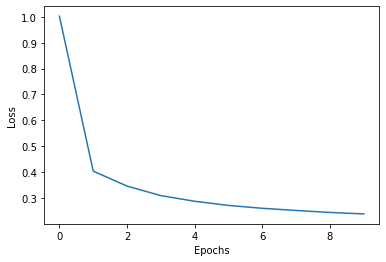

In [40]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [42]:
model_params = 'neural_matrix_factorization.params'

net.save_params(model_params)

C:\Users\Andrea\AppData\Roaming\Python\Python36\site-packages\mxnet\gluon\block.py:461: UserWarning: save_params is deprecated. Please use save_parameters. Note that if you want load from SymbolBlock later, please use export instead. For details, see https://mxnet.apache.org/tutorials/gluon/save_load_params.html
  warnings.warn("save_params is deprecated. Please use save_parameters. "
